In [12]:
import json
import requests
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Metricas y testeo
Se calcularan las metricas de recall y precision para cada una de las categorias que tenemos como ground truth definidas en el archivo cat.txt

### Obtencion de Informacion
Se crearan funciones que permitiran obtener la informacion necesaria para el calculo tanto desde la API como desde el archivo cats.txt procesado que resulta en el archivo testing.txt (Se invirtio la logica del mismo)

In [2]:
def extract_numbers_from_response(api_response):
    numbers = re.findall(r'\d+', api_response)
    return [int(number) for number in numbers]

In [3]:
def read_queries_from_file(file_path):
    queries = []
    with open(file_path, 'r') as file:
        for line in file:
            # Dividir cada línea en dos partes: nombre de la consulta y números
            parts = line.strip().split(': ')
            if len(parts) == 2:
                query_name = parts[0]
                numbers = set(map(int, parts[1].split(', ')))
                queries.append((query_name, numbers))
    return queries

In [4]:
def test_api(query):
    url_tfidf = 'http://127.0.0.1:5000/process/tfidf/'
    url_bow = 'http://127.0.0.1:5000/process/bow/'
    headers = {'Content-Type': 'application/json'}

    payload = {
        "query": query,
    }

    responses = {}

    try:
        response_tfidf = requests.post(url_tfidf, json=payload, headers=headers)
        response_tfidf.raise_for_status()
        data_tfidf = response_tfidf.json()
        first_tfidf_doc = [doc[0] for doc in data_tfidf['cosine_similarities']]
        responses['tfidf'] = extract_numbers_from_response(json.dumps(first_tfidf_doc))
    except requests.exceptions.RequestException as e:
        print(f"Error al hacer la solicitud TF-IDF para query '{query}':", e)
        responses['tfidf'] = None

    try:
        response_bow = requests.post(url_bow, json=payload, headers=headers)
        response_bow.raise_for_status()
        data_bow = response_bow.json()
        first_bow_doc = [doc[0] for doc in data_bow['jaccard_similarities']]
        responses['bow'] = extract_numbers_from_response(json.dumps(first_bow_doc))
    except requests.exceptions.RequestException as e:
        print(f"Error al hacer la solicitud BoW para query '{query}':", e)
        responses['bow'] = None

    return responses

### Calculo de metricas
Se definiran las funciones que se usaran para el calculo de las metricas respectivas

In [5]:
def calculo_precision(predichos, gt):
    TP = len(predichos.intersection(gt))
    FP = len(predichos.difference(gt))
    total = TP + FP
    
    if total == 0:
        return 0.0  # Evita división por cero
    
    precision = TP / total
    return precision * 100

In [6]:
def calculo_recall(predichos, gt):
    TP = len(predichos.intersection(gt))
    FN = len(gt.difference(predichos))
    total = TP + FN
    
    if total == 0:
        return 0.0  # Evita división por cero
    
    recall = TP / total
    return recall * 100

### Creacion de Dataframes
Se usaran dataframes para una mejor visualizacion de los resultados obtenidos

In [7]:
file_path = os.path.join(os.getcwd(), 'reuters', 'testing.txt')
queries = read_queries_from_file(file_path)
df_predictions_bow = pd.DataFrame(columns=['query', 'recall', 'precision'])
df_predictions_tf_idf = pd.DataFrame(columns=['query', 'recall', 'precision'])

### Generación de Métricas
Se iterara a lo largo del contenido del archivo testing y se ira comparando los resultados en el con los resultados de la API cabe mencionar que este proceso se realizo con un umbral de similitud de 0.2 el mismo que debe cambiarse en la API

In [8]:
rows_bow = []
rows_tf_idf = []

for query_name, gt_set in queries:
    response = test_api(query_name)
    results_bow = set(response["bow"])
    results_tf_idf = set(response["tfidf"])

    # Calcula recall y precision para BoW
    new_row_bow = {
        'query': query_name,
        'recall': calculo_recall(results_bow, gt_set),
        'precision': calculo_precision(results_bow, gt_set)
    }
    rows_bow.append(new_row_bow)
    
    # Calcula recall y precision para TF-IDF
    new_row_tf_idf = {
        'query': query_name,
        'recall': calculo_recall(results_tf_idf, gt_set),
        'precision': calculo_precision(results_tf_idf, gt_set)
    }
    rows_tf_idf.append(new_row_tf_idf)

# Convierte las listas de diccionarios a DataFrames
df_predictions_bow = pd.DataFrame(rows_bow)
df_predictions_tf_idf = pd.DataFrame(rows_tf_idf)

### Visualizacion

In [9]:
df_predictions_bow

,query,recall,precision
0,cocoa,65.454545,94.736842
1,sorghum,66.666667,76.190476
2,oat,75.000000,50.000000
3,barley,97.297297,76.595745
4,corn,59.116022,86.290323
...,...,...,...
85,rand,0.000000,0.000000
86,coconut,100.000000,50.000000
87,castor-oil,0.000000,0.000000
88,nkr,0.000000,0.000000


In [10]:
df_predictions_tf_idf

,query,recall,precision
0,cocoa,76.363636,100.000000
1,sorghum,20.833333,83.333333
2,oat,50.000000,57.142857
3,barley,62.162162,85.185185
4,corn,41.988950,95.000000
...,...,...,...
85,rand,100.000000,11.764706
86,coconut,100.000000,80.000000
87,castor-oil,0.000000,0.000000
88,nkr,0.000000,0.000000


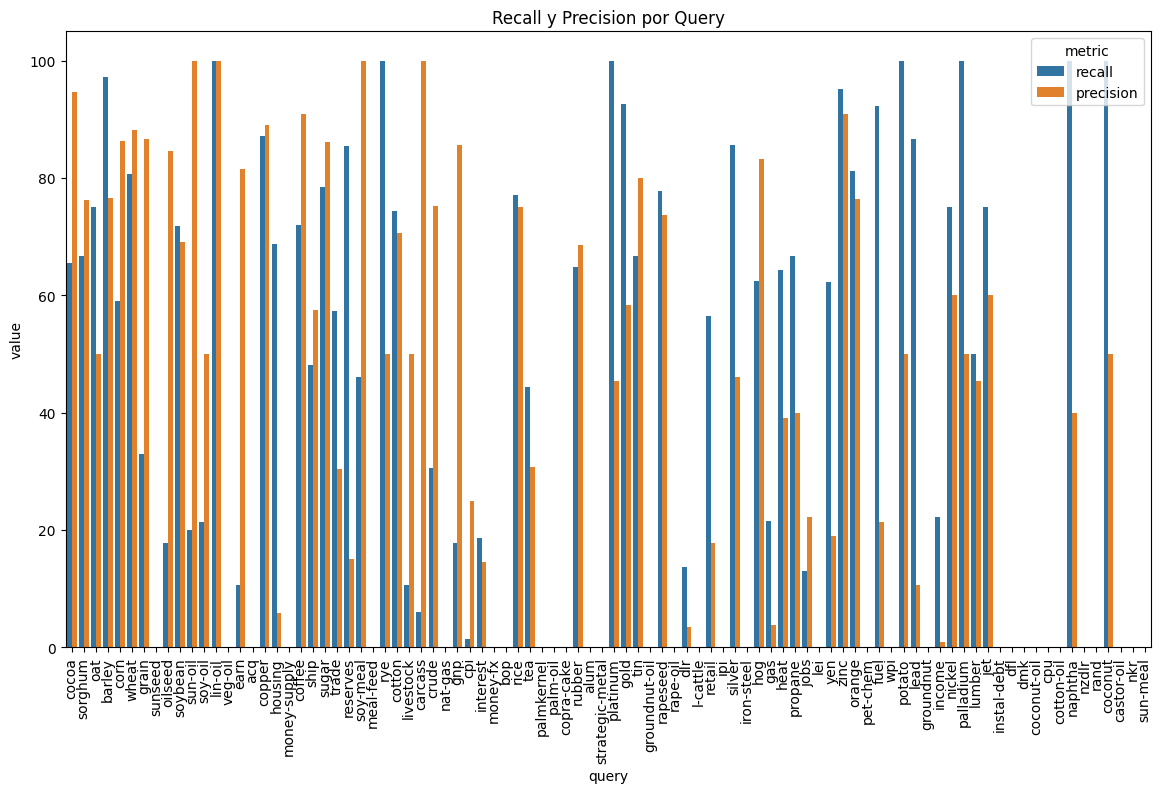

In [14]:
df_melted = df_predictions_bow.melt(id_vars='query', value_vars=['recall', 'precision'], var_name='metric', value_name='value')
plt.figure(figsize=(14, 8))
sns.barplot(x='query', y='value', hue='metric', data=df_melted)
plt.xticks(rotation=90)
plt.title('Recall y Precision por Query')
plt.show()

In [11]:
promedio_recall_bow = df_predictions_bow['recall'].mean()
promedio_precision_bow = df_predictions_bow['precision'].mean()
promedio_recall_tf_idf = df_predictions_tf_idf['recall'].mean()
promedio_precision_tf_idf = df_predictions_tf_idf['precision'].mean()

# Crear un diccionario con los datos
data = {
    'Recall': [promedio_recall_bow, promedio_recall_tf_idf],
    'Precision': [promedio_precision_bow, promedio_precision_tf_idf]
}

# Crear un DataFrame con las filas y columnas especificadas
df_promedios = pd.DataFrame(data, index=['BoW', 'TF-IDF'])

df_promedios

,Recall,Precision
BoW,38.551323,36.144797
TF-IDF,25.144300,41.305972
